# Home Credit LightGBM & CatBoost Model

In [1]:
!pip install cvxpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import logreg_report_v2

# standard library imports
import cvxpy as cp
import gc
import os
import random
import sys
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# third party imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import polars as pl
import pyarrow.parquet as pq
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    log_loss,
    SCORERS, 
    get_scorer,
    classification_report, 
    ConfusionMatrixDisplay, 
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

## imputation on 100k rows train df

In [3]:
data = pd.read_parquet('trian_sample_no_imputation.parquet')

In [4]:
data

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
0,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,NaN,NaN,NaN,2018.0,NaN,a55475b1,ab3c25cf,None,NaN,NaN
1,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,NaN,NaN,NaN,2018.0,NaN,a55475b1,a55475b1,None,NaN,NaN
2,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
3,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
4,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,NaN,NaN,NaN,2017.0,NaN,a55475b1,daf49a8a,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941052,168975,2019-10-21,201910,41,0,0.0,5072.0,6518.2,2536.0,0.0,...,2.0,NaN,NaN,NaN,2010.0,ab3c25cf,a55475b1,None,NaN,NaN
941053,168975,2019-10-21,201910,41,0,0.0,5072.0,6518.2,2536.0,0.0,...,3.0,NaN,NaN,NaN,2010.0,a55475b1,a55475b1,None,NaN,NaN
941054,168975,2019-10-21,201910,41,0,0.0,5072.0,6518.2,2536.0,0.0,...,4.0,NaN,0.0,NaN,2010.0,a55475b1,a55475b1,None,NaN,NaN
941055,168975,2019-10-21,201910,41,0,0.0,5072.0,6518.2,2536.0,0.0,...,2.0,NaN,NaN,2019.0,2007.0,ab3c25cf,ab3c25cf,None,NaN,NaN


In [5]:
# Calculate the threshold for non-null values
threshold = len(data) * 0.80  # N threshold for non-null values

# Filter columns where the count of non-null values is below the threshold
filtered_data = data.dropna(axis=1, thresh=threshold)

# Print or return the resulting DataFrame
print("DataFrame after removing columns with more than 80% null values:")
print(filtered_data)

DataFrame after removing columns with more than 70% null values:
        case_id date_decision   MONTH  WEEK_NUM  target  \
0         12866    2019-04-24  201904        16       0   
1         12866    2019-04-24  201904        16       0   
2         12866    2019-04-24  201904        16       0   
3         12866    2019-04-24  201904        16       0   
4         12866    2019-04-24  201904        16       0   
...         ...           ...     ...       ...     ...   
941052   168975    2019-10-21  201910        41       0   
941053   168975    2019-10-21  201910        41       0   
941054   168975    2019-10-21  201910        41       0   
941055   168975    2019-10-21  201910        41       0   
941056   168975    2019-10-21  201910        41       0   

        actualdpdtolerance_344P  amtinstpaidbefduel24m_4187115A  annuity_780A  \
0                           NaN                             NaN        6064.6   
1                           NaN                             NaN 

In [6]:
train_df = filtered_data
train_df.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,description_351M,financialinstitution_382M,financialinstitution_591M,purposeofcred_426M,purposeofcred_874M,subjectrole_182M,subjectrole_93M,cacccardblochreas_147M,conts_type_509L,num_group2
0,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,a55475b1,a55475b1,P133_127_114,96a8fdfe,a55475b1,daf49a8a,a55475b1,None,HOME_PHONE,0.0
1,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,a55475b1,a55475b1,P133_127_114,96a8fdfe,a55475b1,daf49a8a,a55475b1,None,PRIMARY_MOBILE,1.0
2,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,None,HOME_PHONE,0.0
3,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,None,PRIMARY_MOBILE,1.0
4,12866,2019-04-24,201904,16,0,NaN,NaN,6064.6,0.0,0.0,...,a55475b1,a55475b1,0d39f5db,96a8fdfe,a55475b1,ab3c25cf,ab3c25cf,None,PRIMARY_MOBILE,0.0


In [7]:
train_df.shape

(941057, 171)

In [8]:
null_df = train_df[train_df.columns[train_df.isnull().any()]]

# Impute NaN values with 0 in numerical columns
zero_impute_columns = list(null_df.select_dtypes(exclude="object").columns)
for column in zero_impute_columns:
    train_df[column] = train_df[column].fillna(0)

# Impute NaN values with the mode in categorical columns
mode_impute_columns = list(null_df.select_dtypes(include="object").columns)

for column in mode_impute_columns:
    mode_value = train_df[column].mode()[0]
    train_df[column] = train_df[column].fillna(mode_value)

/tmp/ipykernel_6558/4125252769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[column] = train_df[column].fillna(0)
/tmp/ipykernel_6558/4125252769.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[column] = train_df[column].fillna(mode_value)


In [9]:
train_df.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,description_351M,financialinstitution_382M,financialinstitution_591M,purposeofcred_426M,purposeofcred_874M,subjectrole_182M,subjectrole_93M,cacccardblochreas_147M,conts_type_509L,num_group2
0,12866,2019-04-24,201904,16,0,0.0,0.0,6064.6,0.0,0.0,...,a55475b1,a55475b1,P133_127_114,96a8fdfe,a55475b1,daf49a8a,a55475b1,a55475b1,HOME_PHONE,0.0
1,12866,2019-04-24,201904,16,0,0.0,0.0,6064.6,0.0,0.0,...,a55475b1,a55475b1,P133_127_114,96a8fdfe,a55475b1,daf49a8a,a55475b1,a55475b1,PRIMARY_MOBILE,1.0
2,12866,2019-04-24,201904,16,0,0.0,0.0,6064.6,0.0,0.0,...,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,HOME_PHONE,0.0
3,12866,2019-04-24,201904,16,0,0.0,0.0,6064.6,0.0,0.0,...,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,PRIMARY_MOBILE,1.0
4,12866,2019-04-24,201904,16,0,0.0,0.0,6064.6,0.0,0.0,...,a55475b1,a55475b1,0d39f5db,96a8fdfe,a55475b1,ab3c25cf,ab3c25cf,a55475b1,PRIMARY_MOBILE,0.0


In [10]:
train_df.shape

(941057, 171)

## LightGBM model on 100k rows train df

In [11]:
X, y = train_df.drop(columns=["target"]), train_df["target"]

# Splitting by 'case_id'
case_ids = train_df['case_id'].unique()
train_case_ids, test_case_ids = train_test_split(case_ids, test_size=0.2, random_state=42)

X_train = train_df[train_df['case_id'].isin(train_case_ids)].drop(columns=["target"])
y_train = train_df[train_df['case_id'].isin(train_case_ids)]["target"]
X_test = train_df[train_df['case_id'].isin(test_case_ids)].drop(columns=["target"])
y_test = train_df[train_df['case_id'].isin(test_case_ids)]["target"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,  X_train.select_dtypes(exclude="object").columns),
        ('cat', categorical_transformer,  X_train.select_dtypes(include="object").columns)])


In [12]:
# LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=0)

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("clf", lgb_model),
    ]
)


pipe.fit(X_train, y_train)

y_pred = [probs[1] for probs in pipe.predict_proba(X_train)]

logreg_report_v2.generate_report(pipe, X_train, y_train, list(X_train.columns), ['log_loss'])

logreg_report_v2.generate_report(pipe, X_test, y_test, list(X_test.columns), ['log_loss'])

[LightGBM] [Info] Number of positive: 26135, number of negative: 727712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 19.235256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63403
[LightGBM] [Info] Number of data points in the train set: 753847, number of used features: 24726
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034669 -> initscore=-3.326630
[LightGBM] [Info] Start training from score -3.326630
Log Loss: 0.05554457331324909
AUC: 0.9870973973187577
Gini Stability Score: 0.9088311663730624
Log Loss: 0.14315595115392524
AUC: 0.7635099550615281
Gini Stability Score: 0.3531718887213975


{'AUC': 0.7635099550615281,
 'Gini Stability': 0.3531718887213975,
 'log_loss': 0.14315595115392524}

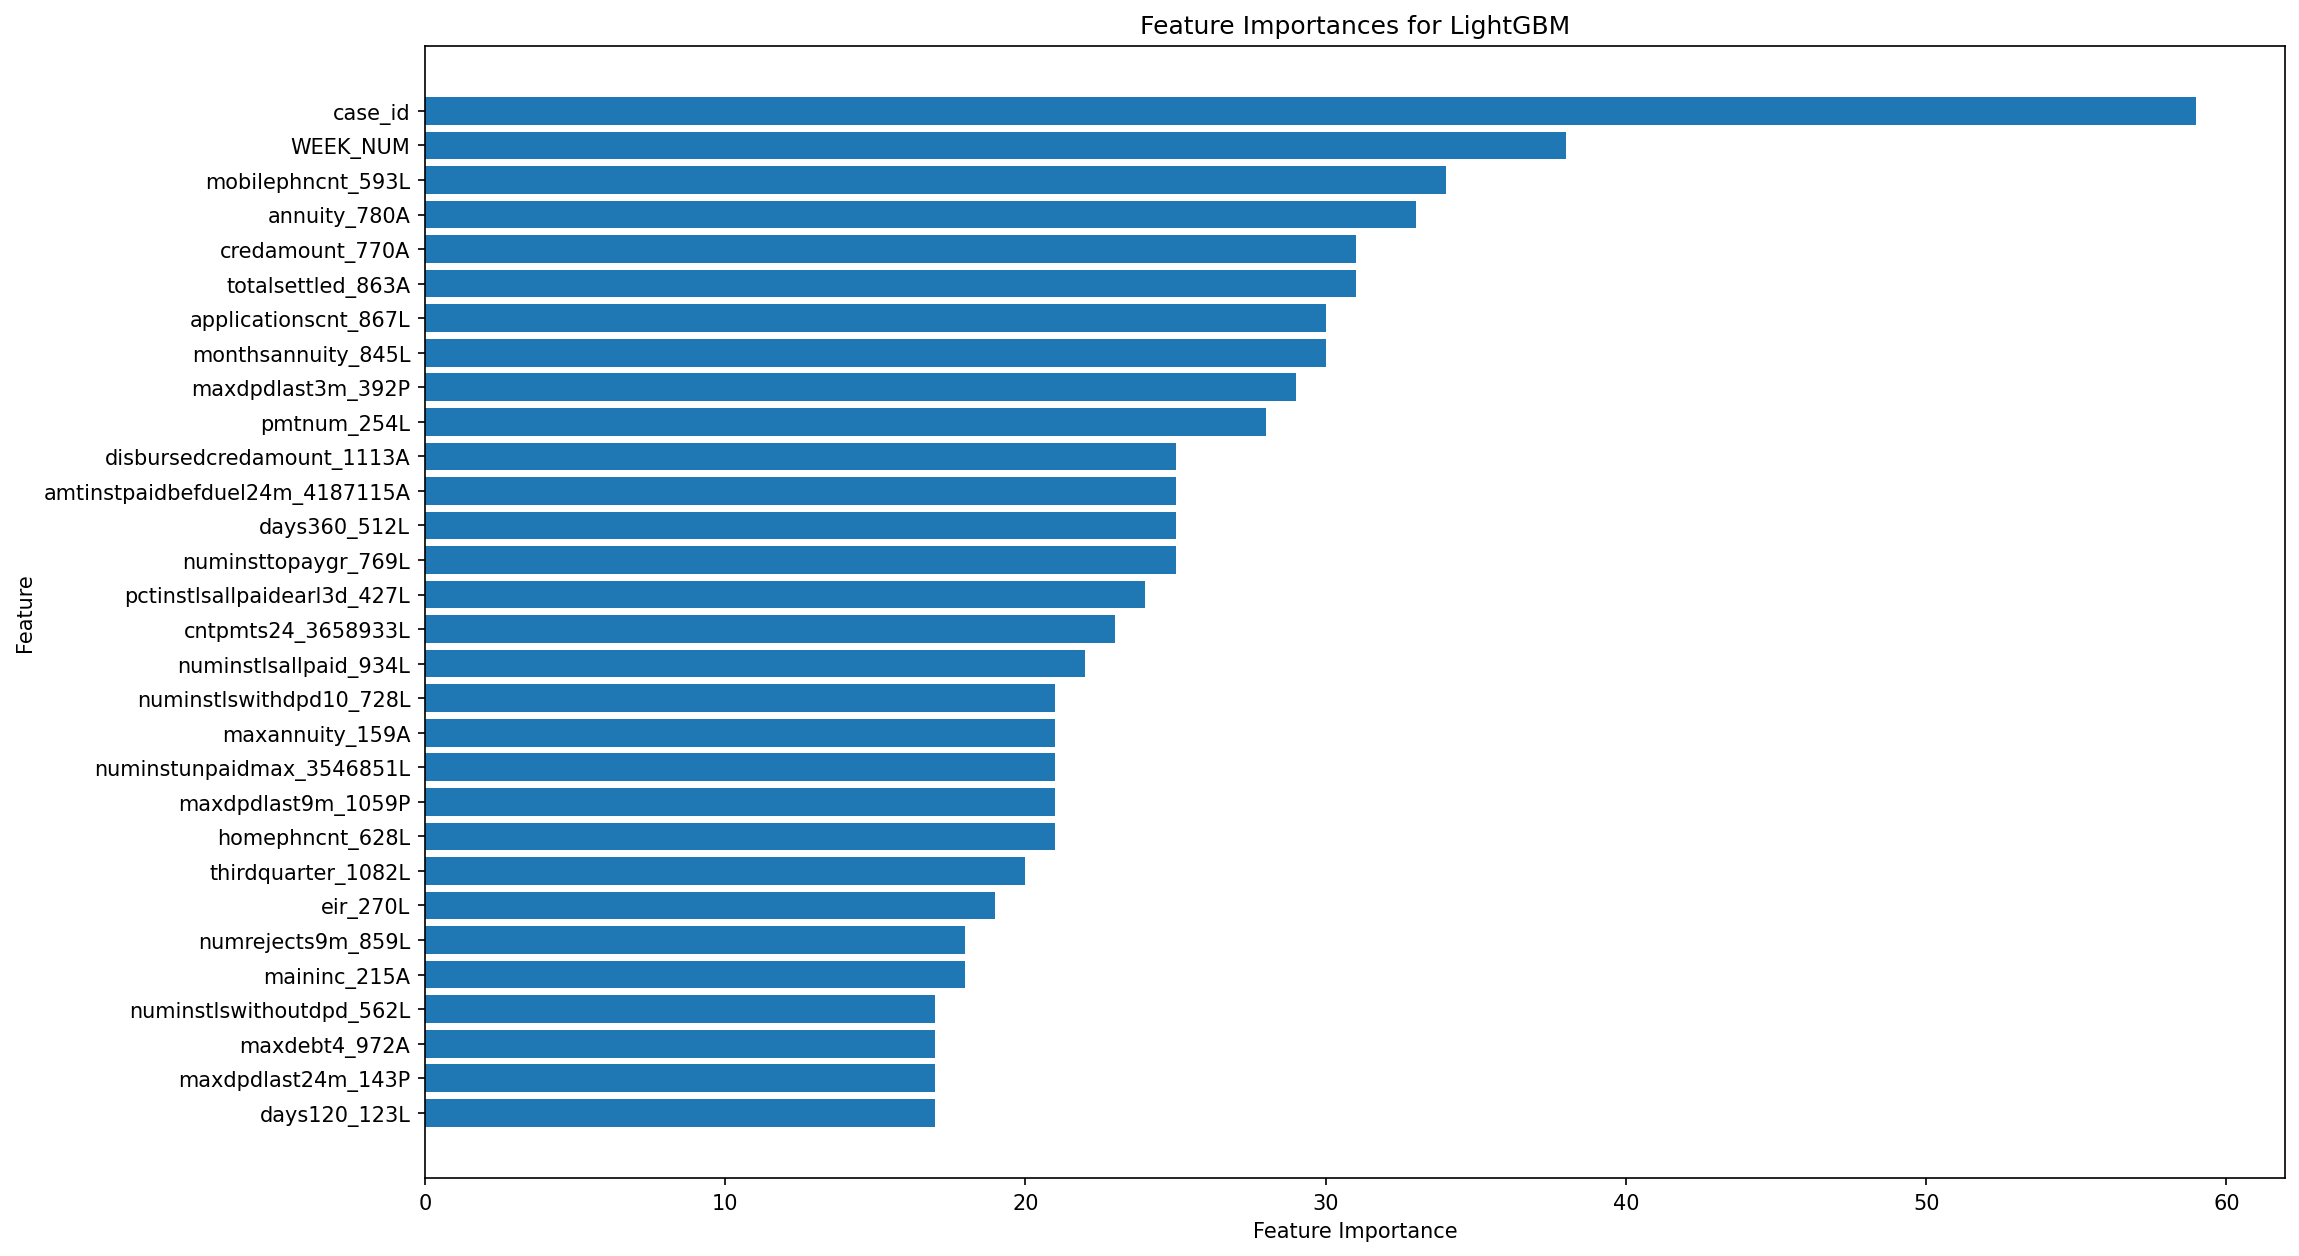

In [13]:
# Extract feature importances
feature_importances = pipe.named_steps['clf'].feature_importances_

# Get feature names from the preprocessor
numeric_features = preprocessor.transformers_[0][2]

# Handle categorical features for different versions of scikit-learn
categorical_transformer = preprocessor.named_transformers_['cat']
if hasattr(categorical_transformer, 'get_feature_names_out'):
    categorical_features = categorical_transformer.get_feature_names_out()
else:
    categorical_features = categorical_transformer.get_feature_names()

feature_names = list(numeric_features) + list(categorical_features)

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort by importance and select top N features
top_N_features = importance_df.sort_values(by='importance', ascending=False).head(30)

# Plotting the feature importances
plt.figure(figsize=(16, 10), dpi = 150)
plt.barh(top_N_features['feature'], top_N_features['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for LightGBM')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### Using Regularization

[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Info] Number of positive: 20955, number of negative: 579762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 16.553452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61543


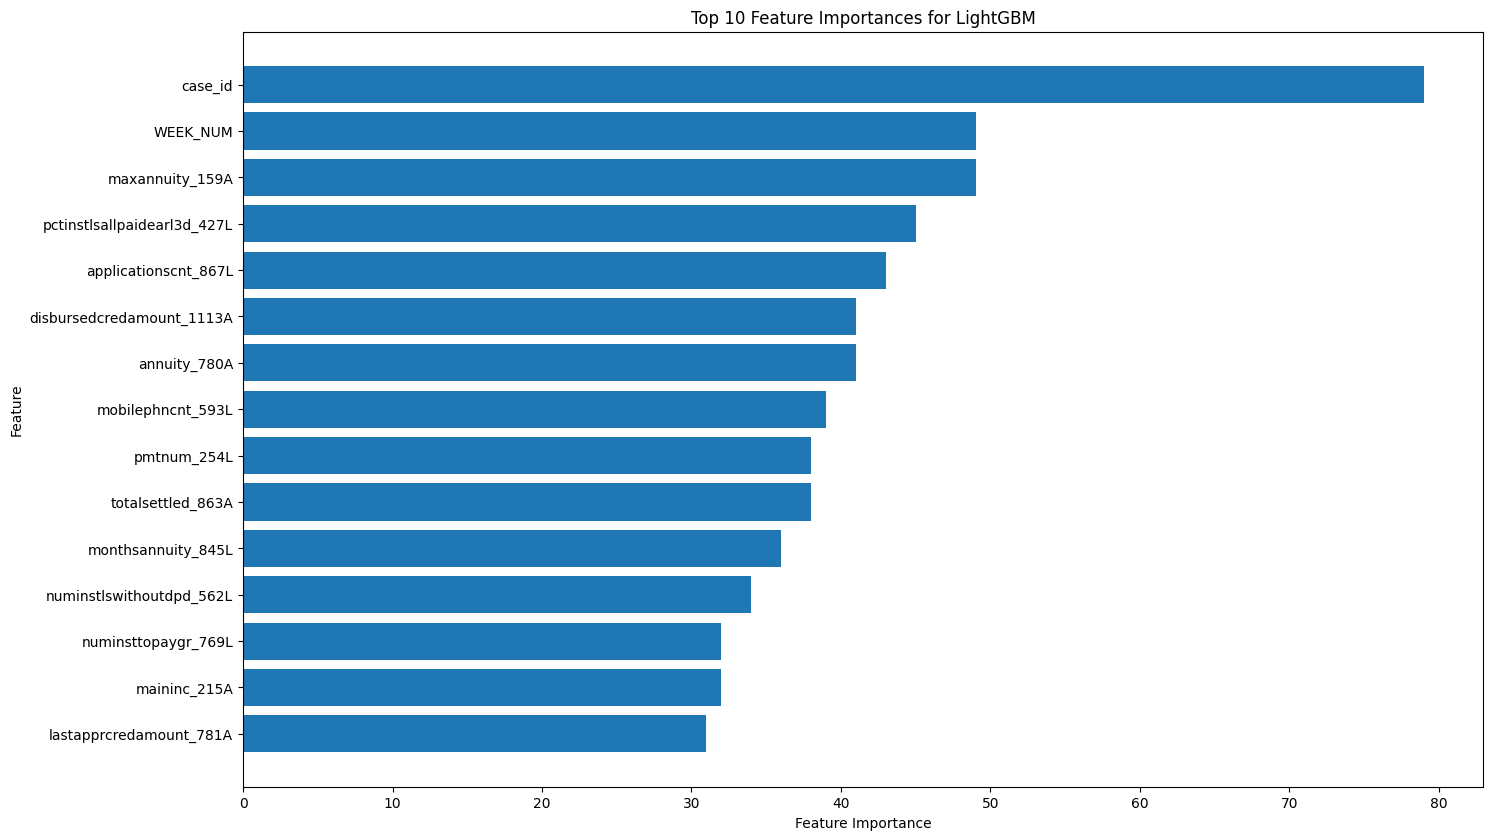

In [14]:
# Use only a sample of the data
sample_size = 750000 
train_df_sample = train_df.sample(n=sample_size, random_state=42)

# Splitting by 'case_id' with the sample
case_ids = train_df_sample['case_id'].unique()
train_case_ids, test_case_ids = train_test_split(case_ids, test_size=0.2, random_state=42)

X_train = train_df_sample[train_df_sample['case_id'].isin(train_case_ids)].drop(columns=["target"])
y_train = train_df_sample[train_df_sample['case_id'].isin(train_case_ids)]["target"]
X_test = train_df_sample[train_df_sample['case_id'].isin(test_case_ids)].drop(columns=["target"])
y_test = train_df_sample[train_df_sample['case_id'].isin(test_case_ids)]["target"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.select_dtypes(exclude="object").columns),
        ('cat', categorical_transformer, X_train.select_dtypes(include="object").columns)])

# LightGBM model with built-in regularization
lgb_model = lgb.LGBMClassifier(
    random_state=0,
    lambda_l1=1.0,  # L1 regularization term
    lambda_l2=1.0,  # L2 regularization term
    min_gain_to_split=0.01  # Minimum gain to split
)

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("clf", lgb_model),
    ]
)

pipe.fit(X_train, y_train)

# Evaluating the model
y_pred_train = pipe.predict_proba(X_train)[:, 1]
y_pred_test = pipe.predict_proba(X_test)[:, 1]

logreg_report_v2.generate_report(pipe, X_train, y_train, list(X_train.columns), ['log_loss'])
logreg_report_v2.generate_report(pipe, X_test, y_test, list(X_test.columns), ['log_loss'])

# Extract feature importances and plot
feature_importances = pipe.named_steps['clf'].feature_importances_

# Get feature names from the preprocessor
numeric_features = preprocessor.transformers_[0][2]
categorical_transformer = preprocessor.named_transformers_['cat']
if hasattr(categorical_transformer, 'get_feature_names_out'):
    categorical_features = categorical_transformer.get_feature_names_out()
else:
    categorical_features = categorical_transformer.get_feature_names()

feature_names = list(numeric_features) + list(categorical_features)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

top_N_features = importance_df.sort_values(by='importance', ascending=False).head(15)

# Plotting the feature importances with lower DPI
plt.figure(figsize=(16, 10), dpi=100)  # Lower DPI for less computational expense
plt.barh(top_N_features['feature'], top_N_features['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances for LightGBM')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### CatBoost w/ Feature Importance and Regularization

0:	learn: 0.5483559	total: 169ms	remaining: 2m 48s
100:	learn: 0.1155076	total: 7.99s	remaining: 1m 11s
200:	learn: 0.1025190	total: 15.9s	remaining: 1m 3s
300:	learn: 0.0932747	total: 23.6s	remaining: 54.9s
400:	learn: 0.0855091	total: 31.6s	remaining: 47.2s
500:	learn: 0.0789270	total: 39.4s	remaining: 39.2s
600:	learn: 0.0734474	total: 47.6s	remaining: 31.6s
700:	learn: 0.0686921	total: 55.8s	remaining: 23.8s
800:	learn: 0.0643875	total: 1m 3s	remaining: 15.8s
900:	learn: 0.0602359	total: 1m 11s	remaining: 7.9s
999:	learn: 0.0566740	total: 1m 19s	remaining: 0us
Log Loss: 0.05670450033365991
AUC: 0.976375892798972
Gini Stability Score: 0.88408612569261
Log Loss: 0.1394548831968323
AUC: 0.7735500470103018
Gini Stability Score: 0.39063634577939077


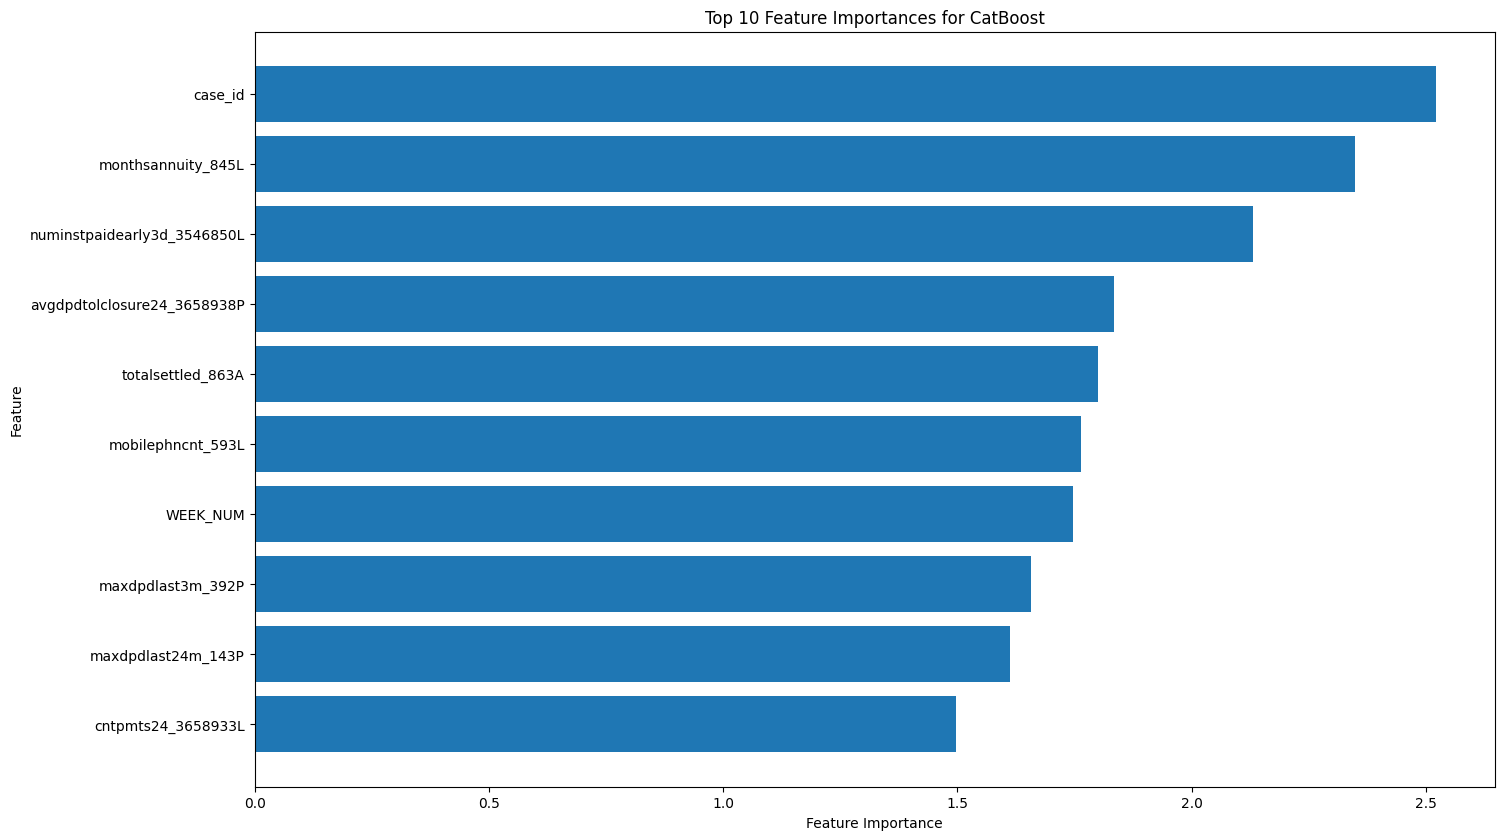

In [15]:
# Use only a sample of the data
sample_size = 500000  # Adjust based on your dataset size
train_df_sample = train_df.sample(n=sample_size, random_state=42)

# Splitting by 'case_id' with the sample
case_ids = train_df_sample['case_id'].unique()
train_case_ids, test_case_ids = train_test_split(case_ids, test_size=0.2, random_state=42)

X_train = train_df_sample[train_df_sample['case_id'].isin(train_case_ids)].drop(columns=["target"])
y_train = train_df_sample[train_df_sample['case_id'].isin(train_case_ids)]["target"]
X_test = train_df_sample[train_df_sample['case_id'].isin(test_case_ids)].drop(columns=["target"])
y_test = train_df_sample[train_df_sample['case_id'].isin(test_case_ids)]["target"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.select_dtypes(exclude="object").columns),
        ('cat', categorical_transformer, X_train.select_dtypes(include="object").columns)])

# CatBoost model with built-in regularization
catboost_model = CatBoostClassifier(
    random_seed=0,
    l2_leaf_reg=3.0,  # L2 regularization term
    depth=6,  # Depth of the trees
    iterations=1000,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    verbose=100  # Output progress
)

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("clf", catboost_model),
    ]
)

pipe.fit(X_train, y_train)

# Evaluating the model
y_pred_train = pipe.predict_proba(X_train)[:, 1]
y_pred_test = pipe.predict_proba(X_test)[:, 1]

logreg_report_v2.generate_report(pipe, X_train, y_train, list(X_train.columns), ['log_loss'])
logreg_report_v2.generate_report(pipe, X_test, y_test, list(X_test.columns), ['log_loss'])

# Extract feature importances and plot
feature_importances = pipe.named_steps['clf'].get_feature_importance()

# Get feature names from the preprocessor
numeric_features = preprocessor.transformers_[0][2]
categorical_transformer = preprocessor.named_transformers_['cat']
if hasattr(categorical_transformer, 'get_feature_names_out'):
    categorical_features = categorical_transformer.get_feature_names_out()
else:
    categorical_features = categorical_transformer.get_feature_names()

feature_names = list(numeric_features) + list(categorical_features)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

top_10_features = importance_df.sort_values(by='importance', ascending=False).head(10)

# Plotting the feature importances 
plt.figure(figsize=(16, 10), dpi=100)  
plt.barh(top_10_features['feature'], top_10_features['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances for CatBoost')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()